In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers
import random
import cv2
from PIL import Image, ImageOps, ImageEnhance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import Model
from keras.callbacks import EarlyStopping
import os
from keras.losses import binary_crossentropy
import sys
from IPython.display import clear_output

In [2]:
dim1 = 480
dim2 = 640

In [3]:
import concurrent.futures
import os
from PIL import Image
import numpy as np

pctr_list = os.listdir('Video to frames/Y')

X = np.empty((len(pctr_list), dim1, dim2, 3), dtype=np.uint8)
Y = np.empty((len(pctr_list), dim1, dim2, 3), dtype=np.uint8)

def preprocess_image(img):
    path_Y = f'Video to frames/Y/{img}'
    path_X = f'Video to frames/X/{img.split("_")[0]}_X.jpg'

    img_X = Image.open(path_X).resize((dim2, dim1))
    data_X = np.array(img_X).astype(np.uint8)

    img_Y = Image.open(path_Y).resize((dim2, dim1))
    data_Y = np.array(img_Y).astype(np.uint8)
    return data_X, data_Y


with concurrent.futures.ThreadPoolExecutor() as executor:
    results = executor.map(preprocess_image, pctr_list)

    for i, (data_X, data_Y) in enumerate(results):
        Y[i] = data_Y
        X[i] = data_X
        print(f'{i+1} from {len(pctr_list)}', end='\r')
        clear_output(wait=True)
        
X, Y = np.delete(X, 0, axis=0), np.delete(Y, 0, axis=0)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
import numpy as np
from tensorflow.keras.layers import Input, Concatenate, Dropout, Conv2D, Activation, BatchNormalization, LeakyReLU, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Cropping2D

In [5]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [6]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [7]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[480, 640, 3])

    down_stack = [
        downsample(128, 3, apply_batchnorm=False), 
        downsample(256, 3), 
        downsample(512, 3), 
        downsample(1024, 3), 
        downsample(1024, 3), 
#         downsample(512, 3), 
#         downsample(512, 3), 
#         downsample(512, 3), 
    ]

    up_stack = [
#         upsample(512, 3, apply_dropout=True), 
#         upsample(512, 3, apply_dropout=True), 
#         upsample(512, 3), 
        upsample(1024, 3, apply_dropout=True), 
        upsample(512, 3, apply_dropout=True), 
        upsample(256, 3, apply_dropout=True), 
        upsample(128, 3, apply_dropout=True), 
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer)

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [8]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[480, 640, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[480, 640, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])

    down1 = downsample(128, 3, False)(x)
    down2 = downsample(256, 3)(down1)
    down3 = downsample(512, 3)(down2)
    down4 = downsample(1024, 3)(down3)

    last = tf.keras.layers.Conv2D(1, 3, strides=1,
                                kernel_initializer=initializer)(down4)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [9]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + LAMBDA*l1_loss

    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


In [10]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [11]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))


In [12]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # First convert the images to float type and then normalize for display
        img = tf.cast(display_list[i], dtype=tf.float32)
        plt.imshow(img * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [13]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        print("Epoch: ", epoch)
        
        # For each epoch, iterate over the test dataset and generate images 
        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        
        # Iterate over the training dataset
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, n)
        print()


In [14]:
generator = Generator()
discriminator = Discriminator()

In [15]:
# Assuming arr is your numpy array
X = np.array_split(X, 3)
Y = np.array_split(Y, 3)

In [16]:
from sklearn.model_selection import train_test_split

# Assuming X and Y are your data
X_train, X_test, Y_train, Y_test = train_test_split(X[0], Y[0], test_size=0.2, random_state=42)

X_train, X_test = X_train.astype('float32') / 127.5 - 1, X_test.astype('float32') / 127.5 - 1
Y_train, Y_test = Y_train.astype('float32') / 127.5 - 1, Y_test.astype('float32') / 127.5 - 1


In [17]:
BATCH_SIZE = 4  # Set your batch size

train_dataset = tf.data.Dataset.from_tensor_slices((Y_train, X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((Y_test, X_test)).batch(BATCH_SIZE)

In [1]:
LAMBDA = 100
EPOCHS = 100
fit(train_dataset, EPOCHS, test_dataset)

NameError: name 'fit' is not defined

In [19]:
# Save the generator
generator.save('generator0.h5')

# Save the discriminator
discriminator.save('discriminator.h5')

In [6]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Load the generator
generator = tf.keras.models.load_model('generator0.h5')
# No need to compile generator as it is used only for inference, not trained directly

# Load the discriminator
discriminator = tf.keras.models.load_model('discriminator.h5')
# Discriminator doesn't need to be compiled either, as you're using custom training loops


In [19]:
def predict(input_image):
    prediction = generator(input_image[None, ...], training=False)  # add batch dimension and set training to False
    return prediction[0]  # remove batch dimension


In [20]:
from PIL import Image
import numpy as np

def load_and_preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((640, 480))  # resize image
    image = np.array(image)  # convert to numpy array
    image = (image / 127.5) - 1  # normalize to [-1, 1]
    return image
pctr_list = os.listdir('Video to frames/New_Y1/')
for i in pctr_list:
    
    image_path = f'Video to frames/New_Y1/{i}'
    input_image = load_and_preprocess_image(image_path)

    # Generate output image
    output_image = predict(input_image)
    # Assuming 'image' is your TensorFlow EagerTensor
    image_normalized = (output_image + 1) / 2 * 255
    image_uint8 = tf.cast(image_normalized, tf.uint8)

    # Convert to BGR format
    image_bgr = cv2.cvtColor(image_uint8.numpy(), cv2.COLOR_RGB2BGR)

    # Save the image as JPEG using OpenCV
    cv2.imwrite(f'Video to frames/New_X2/{i.split("_")[0]}_X.jpg', image_bgr)

In [69]:
import numpy as np
import cv2
import tensorflow as tf

# Assuming 'image' is your TensorFlow EagerTensor
image_normalized = (output_image + 1) / 2 * 255
image_uint8 = tf.cast(image_normalized, tf.uint8)

# Convert to BGR format
image_bgr = cv2.cvtColor(image_uint8.numpy(), cv2.COLOR_RGB2BGR)

# Save the image as JPEG using OpenCV
cv2.imwrite("image.jpg", image_bgr)


True

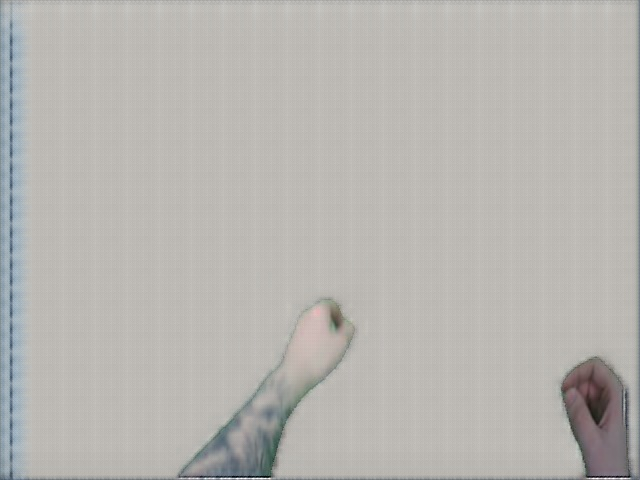

In [70]:
Image.open('image.jpg')